Дано:
2 датафрейма с постами и соответствующими юзерами, поставивших реакции

Оставляем только релевантных юзеров

In [1]:
import pandas as pd
import numpy as np
import json
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('datasets/posts.json', orient='index')
df.reset_index(drop=True, inplace=True)
df

,0,1
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...
...,...,...
561,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...
562,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...
563,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...
564,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...


В идеале нам нужно сходить на линк каждого юзера, отреагировавшего на пост, но алгоритмы Linkedin'а нас быстро забанят. Поэтому будем работать с тем, что есть

In [3]:
df.columns = ['post_text','reacted_users_info']
df

,post_text,reacted_users_info
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...
...,...,...
561,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...
562,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...
563,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...
564,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...


У нас нет большого размеченного датасета чтобы сделать ML-модель определяющую насколько тот или иной юзер для нас релевантен. Поэтому будем визуализировать "облако названий профессий" и убирать из них не-it и около-it специальности.

Оставим профессии со словами `middle`, `senior`, `lead` и исключим нерелевантные специальности

In [4]:
def relevant_users_extraction(reactions_info):
    '''функция фильтрует профессии и оставляет только те, которые соответствуют релевантному паттерну'''
    relevant_list = ['senior', 'middle','lead']
    not_relevant_list = ['hr','recruiter','manager','looking','consultant','seo','консультант', 'management']
    relevant = {}
    job_titles = []
    for link, user_info in reactions_info.items():
        true_pattern = [x in user_info[1].lower() for x in relevant_list]
        wrong_pattern = [x in user_info[1].lower() for x in not_relevant_list]
        pattern = any(true_pattern) and not any(wrong_pattern)
        if pattern:
            relevant[link] = user_info
            job_titles.append(user_info[1])
    job_titles = ' '.join(job_titles)
    return relevant, job_titles

In [5]:
df['relevant_users_info'], df['relevant_users_jobs'] = zip(*df.reacted_users_info.apply(relevant_users_extraction))
df['relevant_reactions_count'] = df.relevant_users_info.apply(len)
df

,post_text,reacted_users_info,relevant_users_info,relevant_users_jobs,relevant_reactions_count
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,Lead Software Test Automation Engineer Lead Fr...,2
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},,0
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},,0
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...,{},,0
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...,{'https://www.linkedin.com/in/ACoAAC4T7VkBePX_...,Lead UX writer and copywriter at Practicum by ...,2
...,...,...,...,...,...
561,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...,{},,0
562,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...,{},,0
563,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...,{},,0
564,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...,{},,0


In [6]:
wc = WordCloud(background_color="white", font_path="./arial.ttf", width=1600, height=800, max_words=1000)
wc.generate(' '.join(df.relevant_users_jobs))

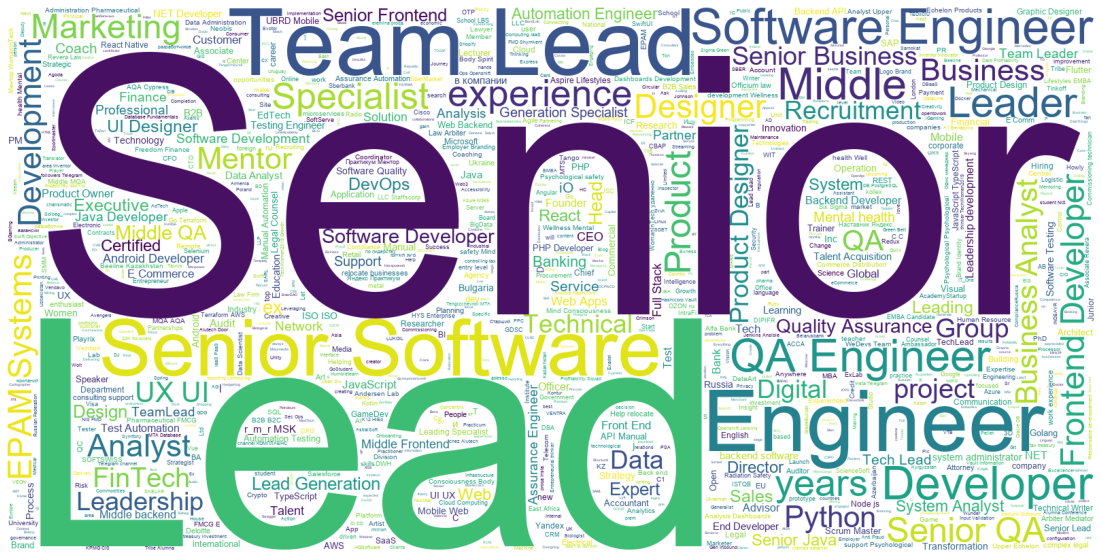

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Остались только релевантные профессии. Удалим полные дубликаты постов

In [8]:
df.drop('relevant_users_jobs', axis=1, inplace=True)
df.drop_duplicates('post_text', inplace=True)
df

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,2
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},0
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},0
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...,{},0
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...,{'https://www.linkedin.com/in/ACoAAC4T7VkBePX_...,2
...,...,...,...,...
561,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...,{},0
562,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...,{},0
563,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...,{},0
564,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...,{},0


In [9]:
df.to_csv('datasets/filtered_posts_df.csv', index=False)